In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from os.path import join

In [37]:
region = 'mixco_3'

geojson_fp = join('..', '..', 'data', region, 'train-'+region+'.geojson')
image_fp = join('..', '..', 'data', region, region+'_ortho-cog.tif')
roof_dir = join('..', '..', 'data', region, 'roofs_train')

In [38]:
with rasterio.open(image_fp) as src:
    profile = src.profile
    print(profile['crs'])
    print(src.profile)
    print(src.bounds)

EPSG:32616
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 19271, 'height': 26066, 'count': 4, 'crs': CRS.from_epsg(32616), 'transform': Affine(0.037884682197416183, 0.0, 114414.52377475728,
       0.0, -0.037884682197416183, 1618709.3919501214), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
BoundingBox(left=114414.52377475728, bottom=1617721.8898239636, right=115144.59948538369, top=1618709.3919501214)


## 1. Get an overview of the scenery

Decimation factor = 32


Text(0.5, 1.0, 'Overview')

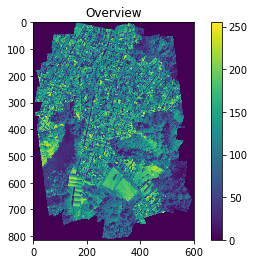

In [39]:
with rasterio.open(image_fp) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor = {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview')

## 2. Cut out roofs and store as separate files

In [40]:
import rasterio
from rasterio.mask import mask
from os import makedirs
from os.path import exists

Create subfolders for each material

In [41]:
materials = ['healthy_metal', 'irregular_metal', 'concrete_cement', 'incomplete', 'other']
for mat in materials:
    directory = join(roof_dir, mat) 
    if not exists(directory):
        makedirs(directory)

Coordinates in GeoJSON label file need to be converted to CSR format of the image

In [42]:
from pyproj import Proj, transform
outProj = Proj(init=profile['crs']) # CRS format of image
inProj = Proj(init='epsg:4326') # lat/lon coordinate format

#### Cutting out roofs
1. Extract the roof id and polygon coordinates from GeoJSON label file
2. Cut the polygon out of the image
3. Save the cut out image of the roof to file with id as name

In [43]:
with open(geojson_fp) as geojson:
    geoms = json.loads(geojson.read())
    roofs = geoms['features']

for roof in roofs:
    roof_id = roof['id']
    roof_geom = roof['geometry']
    roof_material = roof['properties']['roof_material']    
    
    #print(roof_id)
    if roof_geom['type'] == 'MultiPolygon':
        print(roof_id)
        continue

KeyError: 'roof_material'

In [ ]:
with open(geojson_fp) as geojson:
    geoms = json.loads(geojson.read())
    roofs = geoms['features']

for roof in roofs:
    roof_id = roof['id']
    roof_geom = roof['geometry']
    roof_material = roof['properties']['roof_material']    
    
    print(roof_id)
    if roof_geom['type'] == 'MultiPolygon':
        print("MULTIPOLYGON")
        continue
    else:
        coord = roof_geom['coordinates'][0]
        for c in coord:
            c[0], c[1] = transform(inProj, outProj, c[0], c[1])
    
    print(roof_geom)
    with rasterio.open(image_fp) as image:
        roof_image, roof_transform = mask(image, [roof_geom], filled=True, crop=True)
    #show(roof_image)
    roof_meta = image.meta.copy()
    
    # save the resulting raster
    roof_meta.update({"driver": "GTiff",
        "dtype": rasterio.uint8,
        "height": roof_image.shape[1],
        "width": roof_image.shape[2],
        "transform": roof_transform,
        "tiled": True,
        "compress": 'lzw'})
    roof_image_fp = join(roof_dir, roof_material, str(roof_id)+".tif")

    with rasterio.open(roof_image_fp, "w", **roof_meta) as dest:
        dest.write(roof_image)                             

All this can also happen using the module `preprocessing`

In [1]:
import preprocessing

In [2]:
region = 'castries'
preprocessing.preprocess_region(region)

7a24bd7e
7a2cf00c
7a3975e8
7a1d215e
7a42475e
7a40f1d8
7a36a3a4
7a2a88c6
7a352524
7a41f18c
7a3ce822
7a27ad68
7a3a6f02
7a30068e
7a23158c
7a3c1190
7a206c9c
7a2316c2
7a2ea55a
7a266426
7a23d864
7a29139c
7a1f885e
7a43af22
7a3dfb0e
7a35d938
7a25b5c6
7a43e5b4
7a2ed82c
7a2cad68
7a3a8bf4
7a39bdaa
7a229be8
7a31569c
7a318dba
7a322aae
7a3e65da
7a426de2
7a2d2284
7a304996
7a3c0f10
7a292f80
7a38a3a2
7a3bdf7c
7a39582e
7a3f82d0
7a3adc26
7a304e5a
7a327144
7a2fa16c
7a1eda58
7a2955c8
7a385226
7a3dc922
7a32fe48
7a404b84
7a33c13e
7a30b96c
7a2f4348
7a43bb2a
7a2a9b5e
7a3181b2
7a21cb5a
7a3bf12e
7a206f6c
7a406a10
7a409508
7a406434
7a38e920
7a343c04
7a23b3d4
7a3acf92
7a44522e
7a2e1c5c
7a297f76
7a1e764e
7a268834
7a43e7bc
7a39ee4c
7a38be3c
7a3dd9ee
7a35c858
7a3bf76e
7a1f6342
7a2bb714
7a2fb4d6
7a36b538
7a330c3a
7a425136
7a3328a0
7a1faca8
7a2da25e
7a2f26ce
7a44a6f2
7a26ed4c
7a2e9bdc
7a2bf440
7a26aab2
7a20b602
7a27791a
7a1d3252
7a325eac
7a409a76
7a354252
7a20fd92
7a43069e
7a2f3eb6
7a305706
7a3e16ac
7a3d2d8c
7a305990
7

7a4139c2
7a30af26
7a35b1ba
7a38b086
7a2cd7d4
7a332e5e
7a338eda
7a30033c
7a38cf76
7a34228c
7a1d2a1e
7a32a0a6
7a34e730
7a1e254a
7a3a18f4
7a2cb204
7a2cc8c0
7a1d4be8
7a2ab828
7a24e628
7a32a380
7a35a12a
7a30ae4a
7a42c99a
7a3aec84
7a2a090a
7a3a5882
7a26634a
7a429a7e
7a276dd0
7a443c30
7a2658dc
7a29295e
7a3fc9c0
7a33e92a
7a2dfe52
7a3f61ec
7a3ebdc8
7a2e7b02
7a3993de
7a2eff14
7a375650
7a1e129e
7a2d9caa
7a2eb158
7a32df26
7a41ff06
7a43e26c
7a29d336
7a2ba350
7a284ae8
7a29960a
7a213064
7a390e14
7a336964
7a3af800
7a341440
7a23b726
7a309cb6
7a4224a4
7a2f10e4
7a38da20
7a3c4264
7a31f444
7a3b764a
7a1d8950
7a41dd0a
7a3d5992
7a3d4c5e
7a1f6414
7a34294e
7a384aec
7a41d4c2
7a2585a6
7a1dd3ce
7a3473ae
7a1ec31a
7a1ec5f4
7a2564fe
7a3d4506
7a2fb81e
7a445300
7a325dda
7a20b274
7a263e4c
7a2b4540
7a21e7c0
7a3bc348
7a24772e
7a3516ba
7a1dba1a
7a41a358
7a3b958a
7a2651a2
7a3111fa
7a28989a
7a440120
7a3a3488
7a39cc96
7a297576
7a36638a
7a212f06
7a39651c
7a21e13a
7a2dfa9c
7a2f85a6
7a267114
7a2e959c
7a23af74
7a4298d0
7a2b092c
7

7a3e1436
7a32696a
7a3897a4
7a20403c
7a2c11dc
7a28ca18
7a3764b0
7a41e7b4
7a22d9f0
7a36ae6c
7a3cb082
7a44b8b8
7a233210
7a33ec7c
7a3bf69c
7a1fa6f4
7a3a5b7a
7a1e392c
7a37637a
7a37de72
7a35231c
7a3a34f6
7a3ed2e0
7a2f5590
7a20c7e6
7a1f7eea
7a287248
7a312974
7a41fbbe
7a23962e
7a387b16
7a424dc6
7a3b9cba
7a2023fe
7a2caf7a
7a3d46aa
7a3b93e6
7a2d740a
7a3d1a2c
7a44563e
7a337aee
7a3a7e8e
7a1c6b24
7a3a0e9a
7a329a16
7a269298
7a3130e0
7a2822a2
7a2ee38a
7a3f8b04
7a2a45f0
7a2fc61a
7a254bae
7a3375a8
7a26d104
7a3bf26e
7a1da5f2
7a431828
7a3aa990
7a23d2c4
7a1e9cb4
7a32261c
7a32cf90
7a38c576
7a396d14
7a38d5a2
7a28fbb4
7a1ec1e4
7a3b1c0e
7a305b3e
7a399bc2
7a2bf666
7a26db7c
7a1f7666
7a287a4a
7a2cf2f0
7a2e3516
7a28a542
7a400638
7a3444c4
7a2d6956
7a40b3b2
7a1f44c0
7a42262a
7a2f93c0
7a1c6e58
7a41d8e6
7a1f64e6
7a3fcea2
7a3de358
7a43333a
7a38f32a
7a3fd546
7a21c88a
7a2297e2
7a1e2112
7a2b0eae
7a4153f8
7a316916
7a2ddf4e
7a31c79e
7a441b56
7a1d5d72
7a2e820a
7a330d0c
7a2ea97e
7a41a7d6
7a2ea212
7a43d074
7a24279c
7a303186
7

7a36783e
7a2e0c62
7a2ebf54
7a3f887a
7a21ae18
7a447042
7a341d46
7a3abf34
7a1ee660
7a266778
7a3ef91e
7a3c58f8
7a34ef14
7a24fdf2
7a335424
7a4128ce
7a3df4f6
7a308eec
7a2b5080
7a1d438c
7a2a3c68
7a2e2dfa
7a1f168a
7a2c58a4
7a3c8be8
7a3af062
7a2104e0
7a3eba76
7a36843c
7a2231b2
7a241cac
7a3c9ed0
7a1fa05a
7a2ae19a
7a4267fc
7a1d0250
7a29a51e
7a206e40
7a361a38
7a2d473c
7a1d7546
7a381130
7a3fc7ae
7a2ee592
7a259cb2
7a29938a
7a3d5c6c
7a432232
7a2589d4
7a297a12
7a374228
7a20fec8
7a3250ec
7a3698b4
7a28d17a
7a2c12ae
7a2355c4
7a2aa3ce
7a2b300a
7a1e0e66
7a2a1bc0
7a284552
7a2ee8da
7a381356
7a2f6ba2
7a27ea76
7a250c8e
7a2a235e
7a26846a
7a26a954
7a38514a
7a3fd8a2
7a40278a
7a3f9d6a
7a443e38
7a3a1336
7a2cc92e
7a33f668
7a1fffe6
7a384c9a
7a33bebe
7a403270
7a21c218
7a348498
7a2e6f40
7a43f4e6
7a279882
7a2423d2
7a1e522c
7a2a0b26
7a24aba4
7a374570
7a388a20
7a277f5a
7a2ddd32
7a2a8f06
7a3bf840
7a32dd1e
7a3eb44a
7a39f93c
7a229508
7a2310f0
7a376ad2
7a241ec8
7a3d3692
7a265c38
7a3a2d9e
7a32d418
7a3a5670
7a1fd8f4
7a1f6964
7

7a20c8ae
7a3b6326
7a25613e
7a312ece
7a263ffa
7a432a8e
7a42c63e
7a21e068
7a1d2f8c
7a3bbc36
7a1e2392
7a448096
7a2ddcc4
7a2fb2c4
7a3905d6
7a344d7a
7a1ca2e2
7a41559c
7a40f070
7a34d100
7a3e3e02
7a22ae1c
7a3b1844
7a2859f2
7a3440a0
7a3faf44
7a1e570e
7a4477fe
7a2fd560
7a411be0
7a375092
7a393cb8
7a442042
7a349ec4
7a1c6458
7a1e358a
7a3373a0
7a341f8a
7a3718f2
7a23b1a4
7a285204
7a31bee8
7a398b28
7a305774
7a3a0c06
7a308816
7a2fa806
7a3cb514
7a1d288e
7a2d3da0
7a30f292
7a382a58
7a32e80e
7a3f5012
7a30b340
7a2cc38e
7a3253da
7a30b12e
7a24ce7c
7a317014
7a3a05e4
7a3dd28c
7a2719ac
7a3d37d2
7a3d6cca
7a2530d8
7a3ed844
7a2f15ee
7a2a7be2
7a2bdaf0
7a2322ca
7a326d16
7a25ac8e
7a3e3fa6
7a24cb7a
7a3c4ad4
7a36271c
7a3ff2ce
7a24b0b8
7a2e7882
7a381572
7a32646a
7a211908
7a27053e
7a1d517e
7a28a8bc
7a41f394
7a2c110a
7a2670a6
7a249e48
7a403428
7a3db7e8
7a365ea8
7a1d84f0
7a34bbf2
7a2402d0
7a42c71a
7a3ee3c0
7a310534
7a2fa1d0
7a2c3540
7a254d5c
7a3690b2
7a27e2c4
7a2d2bbc
7a24a9ec
7a2e6fae
7a3de768
7a3bacf0
7a3a035a
7a4464e4
7

7a2470bc
7a324444
7a28df08
7a350f58
7a3e9bfe
7a2acff2
7a26bb56
7a344316
7a29613a
7a36f21e
7a27deaa
7a351a7a
7a285484
7a445094
7a3793cc
7a2d9174
7a439c62
7a270322
7a29b9b4
7a23bc80
7a23f29a
7a1c9108
7a282d88
7a3b5728
7a3bb678
7a33a32a
7a239d54
7a379994
7a3c9e62
7a1e1438
7a2213f8
7a34a9f0
7a26fda0
7a402fe6
7a2e07da
7a41ea34
7a2c6146
7a3a4162
7a38f24e
7a446138
7a2018b4
7a421e64
7a3ad140
7a2c6b32
7a1ebf00
7a2c1a1a
7a3876de
7a43d006
7a3c4336
7a211f16
7a38e98e
7a3c6f14
7a2a2ebc
7a3235b2
7a303730
7a2ae834
7a371fa0
7a3b2258
7a21a8e6
7a225f70
7a417194
7a231442
7a3b3518
7a29ac6c
7a374020
7a1c91e4
7a3f42e8
7a35d302
7a368572
7a257a52
7a25cf0c
7a22dd7e
7a20df10
7a3b4918
7a2dbdca
7a2e357a
7a35bfac
7a3d28fa
7a39a89c
7a2107b0
7a25a4a0
7a246004
7a1d1056
7a442182
7a346b02
7a33689c
7a361e66
7a32c11c
7a39034c
7a3cb302
7a32557e
7a3ff8b4
7a3fbbe2
7a329372
7a262efc
7a26d3f2
7a3e8aba
7a28f2ea
7a2e3016
7a420046
7a4246fa
7a1ccf38
7a26761e
7a1de86e
7a3a6e94
7a3d84e4
7a35aa3a
7a34f54a
7a1fabe0
7a39d3a8
7a3d4ac4
7

7a32d760
7a2330c6
7a3dea4c
7a233756
7a3586fe
7a3bb8ee
7a3a8b18
7a2437aa
7a33132e
7a1d802c
7a3f9ffe
7a280664
7a408388
7a286186
7a2bef54
7a3903ba
7a3ee564
7a299ed4
7a42fcbc
7a43af90
7a3a43ce
7a3da230
7a2eb374
7a2a3b96
7a2f7660
7a3a6c1e
7a1ffaa0
7a2194d2
7a23b88e
7a22e0e4
7a1dd022
7a34117a
7a365dd6
7a1d4256
7a2a78b8
7a354964
7a297f12
7a37a434
7a358f3c
7a1ed198
7a3d2544
7a22b1c8
7a3d55dc
7a251a12
7a407fc8
7a2c1f74
7a28aa6a
7a37bd70
7a1d530e
7a29ba22
7a38a4e2
7a3fc664
7a30ca60
7a352a88
7a3ff54e
7a2ebcd4
7a3bca6e
7a2c4896
7a244baa
7a1d6d58
7a25ca5c
7a38a546
7a352592
7a33bbda
7a2b61c4
7a36b880
7a384f9c
7a421a04
7a333c3c
7a3081cc
7a2519a4
7a27c6ea
7a428dea
7a26d4c4
7a2fb256
7a1d07f0
7a342584
7a2ce4c2
7a422ea4
7a415b8c
7a39ab80
7a30ce16
7a2756b0
7a33c558
7a259956
7a331126
7a315be2
7a2046ae
7a3891d2
7a3c16f4
7a1eb79e
7a3dd084
7a252872
7a3205a6
7a33989e
7a40e01c
7a2810a0
7a1fe8d0
7a1f6f0e
7a2b1390
7a31f4b2
7a21413a
7a39352e
7a3c5df8
7a3754ac
7a38cbb6
7a3f4432
7a2789dc
7a322478
7a1d9bfc
7a1f8ade
7

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data\\castries\\test-castries.geojson'

In [ ]:
preprocessing.greetings()